# Downloading Satellite Images 
This notebook outlines the steps to download satellite imagery from Mapbox API and create top-down satellite chips for individual buildings. Users need to register for their own API token via: https://docs.mapbox.com/help/getting-started/access-tokens/#how-access-tokens-work

### Import libraries and packages

In [3]:
import os
import rasterio
from rasterio.merge import merge
import math
import requests, json
import urbanity as urb
from urbanity.geom import project_gdf
from urbanity.utils import get_gadm
from urbanity.geom import fill_and_expand, project_gdf
import mercantile
import numpy as np
import networkx as nx
import pandas as pd
import datetime as dt
from dateutil import tz
from shapely import geometry
from shapely.geometry import box
from shapely.geometry import Point, Polygon
# from mapbox_vector_tile import decode
# from vt2geojson.tools import vt_bytes_to_geojson
# from vt2geojson.features import Layer, Feature
from rtree.index import Index as RTreeIndex
from dateutil.zoneinfo import get_zonefile_instance
from pyrosm.data import sources
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from PIL import Image
plt.rcdefaults()

### Import mapbox key

In [4]:
with open('../data/api_key.json', 'r') as f:
    api_key = json.load(f)['mapbox']

### Download city boundary

In [5]:
# Load demo area in Seattle
seattle_squire = gpd.read_parquet('../data/Seattle_Squire_Park.parquet')

### Get vector tiles 

In [6]:
# Get vector tiles to download image satellite chips
bbox = list(seattle_squire.geometry.total_bounds)

def get_tiles_from_bbox(bbox: list = None,
                        zoom = 18):

    tiles = list(mercantile.tiles(bbox[0], bbox[1], bbox[2], bbox[3], zoom))
    
    return tiles

tiles = get_tiles_from_bbox(bbox)

### Get raster images corresponding to each tile

In [9]:
def download_satellite_tiles_from_bbox(bbox, api_key: str):
    # Make directory
    tiles = get_tiles_from_bbox(bbox) 
    
    # Add spatial filter here
    
    for tile in tiles[:]:
        tile_url = 'https://api.mapbox.com/v4/mapbox.satellite/{}/{}/{}@2x.jpg90?'.format(tile.z,tile.x,tile.y)
        response = requests.get(tile_url, params={'access_token': api_key})
        img_path = f"../satellite_data/{tile.z}_{tile.x}_{tile.y}.jpg"
        print(f'Downloaded tile: {tile.z}/{tile.x}/{tile.y}')
        
        with open(img_path, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)

In [10]:
download_satellite_tiles_from_bbox(bbox, api_key)

Downloaded tile: 18/42003/91530
Downloaded tile: 18/42003/91531
Downloaded tile: 18/42003/91532
Downloaded tile: 18/42003/91533
Downloaded tile: 18/42003/91534
Downloaded tile: 18/42003/91535
Downloaded tile: 18/42003/91536
Downloaded tile: 18/42003/91537
Downloaded tile: 18/42003/91538
Downloaded tile: 18/42003/91539
Downloaded tile: 18/42003/91540
Downloaded tile: 18/42003/91541
Downloaded tile: 18/42003/91542
Downloaded tile: 18/42003/91543
Downloaded tile: 18/42003/91544
Downloaded tile: 18/42003/91545
Downloaded tile: 18/42003/91546
Downloaded tile: 18/42003/91547
Downloaded tile: 18/42003/91548
Downloaded tile: 18/42003/91549
Downloaded tile: 18/42003/91550
Downloaded tile: 18/42003/91551
Downloaded tile: 18/42003/91552
Downloaded tile: 18/42003/91553
Downloaded tile: 18/42003/91554
Downloaded tile: 18/42003/91555
Downloaded tile: 18/42003/91556
Downloaded tile: 18/42003/91557
Downloaded tile: 18/42003/91558
Downloaded tile: 18/42003/91559
Downloaded tile: 18/42003/91560
Download

### Visualise raster image

In [11]:
def visualise_raster_img(img_path):
    with rasterio.open(img_path) as f:
        dataset = f.read()
    plt.imshow(np.transpose(dataset, (1, 2, 0)))

In [17]:
img_path = f"../satellite_data/{tiles[0].z}_{tiles[0].x}_{tiles[0].y}.jpg"

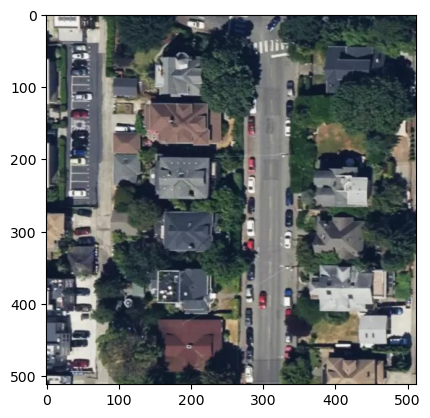

In [18]:
visualise_raster_img(img_path)

### Get GeoDataFrame representation of mercantile tiles

In [21]:
seattle_proj = project_gdf(seattle_squire)
seattle_proj['geometry'] = seattle_proj.buffer(200)
seattle_proj = seattle_proj.to_crs('epsg:4326')

In [22]:
def get_tiles_gdf(tiles, bounds = None):
    x_list, y_list, z_list = [], [], []
    
    geom = []
    for tile in tiles:
        x_list.append(tile.x)
        y_list.append(tile.y)
        z_list.append(tile.z)
        geom.append(geometry.box(*mercantile.bounds(tile)))
    df = pd.DataFrame({'X': x_list, 'Y': y_list, 'Z': z_list})
    gdf = gpd.GeoDataFrame(data=df, crs = 'epsg:4326', geometry=geom)
    gdf['GID'] = range(len(gdf))
    
    if bounds is not None:
        intersect = bounds.overlay(gdf)
        selected_grids = gdf[gdf['GID'].isin(list(intersect['GID']))]
        selected_grids = selected_grids[['X','Y','Z','geometry']]

        return selected_grids
    
    return gdf

In [23]:
tiles_gdf = get_tiles_gdf(tiles, bounds=seattle_proj)

<Axes: >

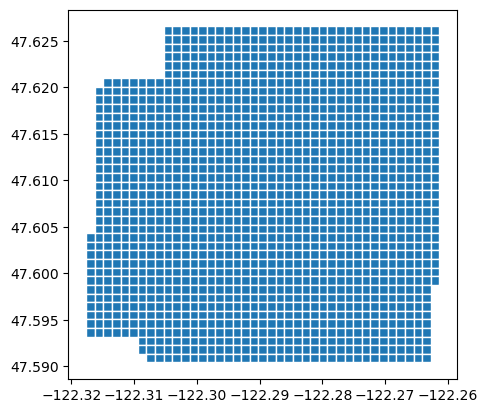

In [25]:
tiles_gdf.plot(edgecolor='white')

In [26]:
tiles_gdf_proj = project_gdf(tiles_gdf)

In [27]:
# Add tile_id column
def get_tile_id(row):
    return str(row['Z']) + '/' + str(row['X']) + '/' + str(row['Y'])

tiles_gdf_proj['tile_id'] = tiles_gdf_proj.apply(lambda row: get_tile_id(row), axis=1)

In [28]:
tiles_gdf_proj

,X,Y,Z,geometry,tile_id
24,42003,91554,18,"POLYGON ((551391.702 5272446.124, 551390.796 5...",18/42003/91554
25,42003,91555,18,"POLYGON ((551392.609 5272343.215, 551391.702 5...",18/42003/91555
26,42003,91556,18,"POLYGON ((551393.516 5272240.304, 551392.609 5...",18/42003/91556
27,42003,91557,18,"POLYGON ((551394.423 5272137.391, 551393.516 5...",18/42003/91557
28,42003,91558,18,"POLYGON ((551395.33 5272034.477, 551394.423 52...",18/42003/91558
...,...,...,...,...,...
1585,42043,91555,18,"POLYGON ((555521.616 5272381.065, 555520.636 5...",18/42043/91555
1586,42043,91556,18,"POLYGON ((555522.595 5272278.154, 555521.616 5...",18/42043/91556
1587,42043,91557,18,"POLYGON ((555523.575 5272175.242, 555522.595 5...",18/42043/91557
1588,42043,91558,18,"POLYGON ((555524.555 5272072.327, 555523.575 5...",18/42043/91558


### Download edge tiles from boundary

In [29]:
def download_satellite_tiles_from_gdf(gdf, api_key: str):
    # Make directory
    for i, row in gdf.iterrows():
        tile_url = 'https://api.mapbox.com/v4/mapbox.satellite/{}/{}/{}@2x.jpg90?'.format(row.Z,row.X,row.Y)
        response = requests.get(tile_url, params={'access_token': api_key})
        img_path =  f"../satellite_data/{row.Z}_{row.X}_{row.Y}.jpg"

        print(f'Downloaded tile: {row.Z}/{row.X}/{row.Y}')
        
        if not os.path.exists(img_path):
            with open(img_path, 'wb') as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)

In [30]:
download_satellite_tiles_from_gdf(tiles_gdf_proj, api_key)

Downloaded tile: 18/42003/91554
Downloaded tile: 18/42003/91555
Downloaded tile: 18/42003/91556
Downloaded tile: 18/42003/91557
Downloaded tile: 18/42003/91558
Downloaded tile: 18/42003/91559
Downloaded tile: 18/42003/91560
Downloaded tile: 18/42003/91561
Downloaded tile: 18/42003/91562
Downloaded tile: 18/42003/91563
Downloaded tile: 18/42003/91564
Downloaded tile: 18/42003/91565
Downloaded tile: 18/42004/91537
Downloaded tile: 18/42004/91538
Downloaded tile: 18/42004/91539
Downloaded tile: 18/42004/91540
Downloaded tile: 18/42004/91541
Downloaded tile: 18/42004/91542
Downloaded tile: 18/42004/91543
Downloaded tile: 18/42004/91544
Downloaded tile: 18/42004/91545
Downloaded tile: 18/42004/91546
Downloaded tile: 18/42004/91547
Downloaded tile: 18/42004/91548
Downloaded tile: 18/42004/91549
Downloaded tile: 18/42004/91550
Downloaded tile: 18/42004/91551
Downloaded tile: 18/42004/91552
Downloaded tile: 18/42004/91553
Downloaded tile: 18/42004/91554
Downloaded tile: 18/42004/91555
Download

### Get grid size per grid

In [31]:
def get_grid_size(tile_gdf_proj):
    x_grid_size = (tile_gdf_proj.iloc[[0]].geometry.total_bounds[2] - tile_gdf_proj.iloc[[0]].geometry.total_bounds[0])/512
    y_grid_size = (tile_gdf_proj.iloc[[0]].geometry.total_bounds[3] - tile_gdf_proj.iloc[[0]].geometry.total_bounds[1])/512
    return x_grid_size, y_grid_size

In [33]:
get_grid_size(tiles_gdf_proj)

(0.20337595861815316, 0.20276556755197817)

### Load buildings

In [4]:
buildings = gpd.read_parquet('../data/demo_seattle_buildings.parquet')

In [35]:
proj_buildings = project_gdf(buildings)

In [36]:
def get_max_img_dims(buildings_proj):
    ''' Helper function to return the maximum number of pixels in length and width to determine image chipset size'''
    
    bounds_df = buildings_proj.geometry.bounds
    x_max = max(bounds_df['maxx'] - bounds_df['minx'])
    y_max = max(bounds_df['maxy'] - bounds_df['miny'])
    total_max = max(x_max, y_max)
    half_max = total_max / 2
    return total_max, half_max

In [37]:
total_max, half_max = get_max_img_dims(proj_buildings)

In [38]:
def get_building_image_chips(building_proj, tiles_gdf_proj, add_context = False, pad_npixels = 128):    
    # Project building to local coordinates
    building_chips = building_proj.copy()
    
    if add_context:
        geom_list = []
        x_grid_size, y_grid_size = get_grid_size(tiles_gdf_proj)
        building_chips['geometry'] = building_chips['geometry'].bounds.apply(lambda row: geometry.box(row['minx']-x_grid_size*pad_npixels, 
                                                                                                      row['miny']-y_grid_size*pad_npixels, 
                                                                                                      row['maxx']+x_grid_size*pad_npixels, 
                                                                                                      row['maxy']+y_grid_size*pad_npixels), axis=1)
    else: 
        building_chips['geometry'] = building_chips['geometry'].bounds.apply(lambda row: geometry.box(row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1)
    
    return building_chips

In [39]:
building_chips = get_building_image_chips(proj_buildings, tiles_gdf_proj, add_context=True)

<Axes: >

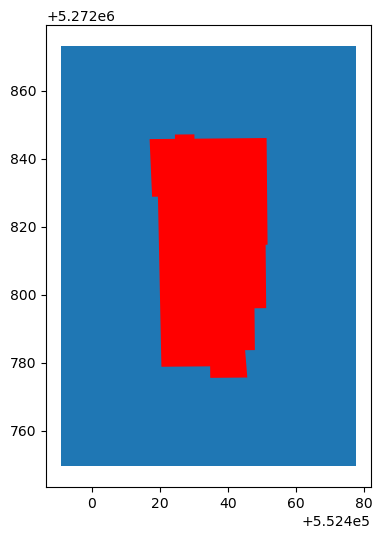

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
building_chips.iloc[[3]].plot(ax=ax)
proj_buildings.iloc[[3]].plot(ax=ax, color='red')

In [41]:
def get_and_combine_tiles(tiles_gdf_proj, building_chips, data_folder, output_folder):
    ''' Helper function to crop satellite image to desired building chip sizes'''
    
    # Create directory to store building satellite image chips
    if os.path.exists(os.path.join(os.getcwd(), output_folder)):
        pass
    else:
        os.makedirs(os.path.join(os.getcwd(), output_folder))
        
    # Obtain chosen satellite images
    chosen_tiles = tiles_gdf_proj.overlay(building_chips)
    
    x_grid_size, y_grid_size = get_grid_size(tiles_gdf_proj)
    
    for bid in chosen_tiles['bid'].unique():
    # for bid in uncovered:  
        temp_gdf = chosen_tiles[chosen_tiles['bid'] == bid]
        columns = []
        # First loop over x values
        for x_val in temp_gdf['X'].unique():
            x_gdf = temp_gdf[temp_gdf['X'] == x_val]
            
            rasters = []
            for i, row in x_gdf.iterrows():
                raster_path = os.path.join(os.getcwd(), data_folder, f"{row['Z']}_{row['X']}_{row['Y']}.jpg")
                with rasterio.open(raster_path) as f:
                    raster = f.read()
                    rasters.append(raster)
            
            columns.append(np.concatenate((rasters), axis=1))
            
        try:  
            # Combine satellite chips into single image
            img = np.concatenate((columns), axis=2)    
            # Extract building from image
            b_minx, b_miny, b_maxx, b_maxy =  building_chips[building_chips['bid'] == bid]['geometry'].bounds.values[0]
            tile_minx, tile_miny, tile_maxx, tile_maxy = tiles_gdf_proj[tiles_gdf_proj['tile_id'].isin(list(chosen_tiles[chosen_tiles['bid'] == bid]['tile_id']))].total_bounds
            
            img_x_start = int((b_minx - tile_minx) / x_grid_size)
            img_y_start = int((tile_maxy-b_maxy) / y_grid_size)
            img_x_end = int((b_maxx - b_minx) / x_grid_size) + img_x_start
            img_y_end = img_y_start + int((b_maxy - b_miny) / y_grid_size)
            cropped_img = img[:, img_y_start:img_y_end, img_x_start:img_x_end]
            print(f'Saving image chip for building: {bid}.')
            # Save image chip for building
            try:
                im = Image.fromarray(np.transpose(cropped_img, (1, 2, 0)))
                im.save(os.path.join(os.getcwd(), output_folder, f"{bid}.png"))
            except ValueError:
                print(f'Cannot save: {bid}.')
                
        except ValueError:
            print(f'Error in dim size for {bid}.')

In [43]:
get_and_combine_tiles(tiles_gdf_proj, building_chips, '../satellite_data/', '../building_satellite/')

Saving image chip for building: 228732764.
Saving image chip for building: 228732889.
Saving image chip for building: 228732763.
Saving image chip for building: 337666939.
Saving image chip for building: 337666940.
Saving image chip for building: 337666941.
Saving image chip for building: 337666942.
Saving image chip for building: 337666943.
Saving image chip for building: 337666944.
Saving image chip for building: 235387610.
Saving image chip for building: 235387622.
Saving image chip for building: 235387701.
Saving image chip for building: 235387739.
Saving image chip for building: 235387612.
Saving image chip for building: 235387623.
Saving image chip for building: 235387680.
Saving image chip for building: 235387764.
Saving image chip for building: 235387803.
Saving image chip for building: 235387811.
Saving image chip for building: 235387816.
Saving image chip for building: 906291536.
Saving image chip for building: 906291537.
Saving image chip for building: 235387676.
Saving imag

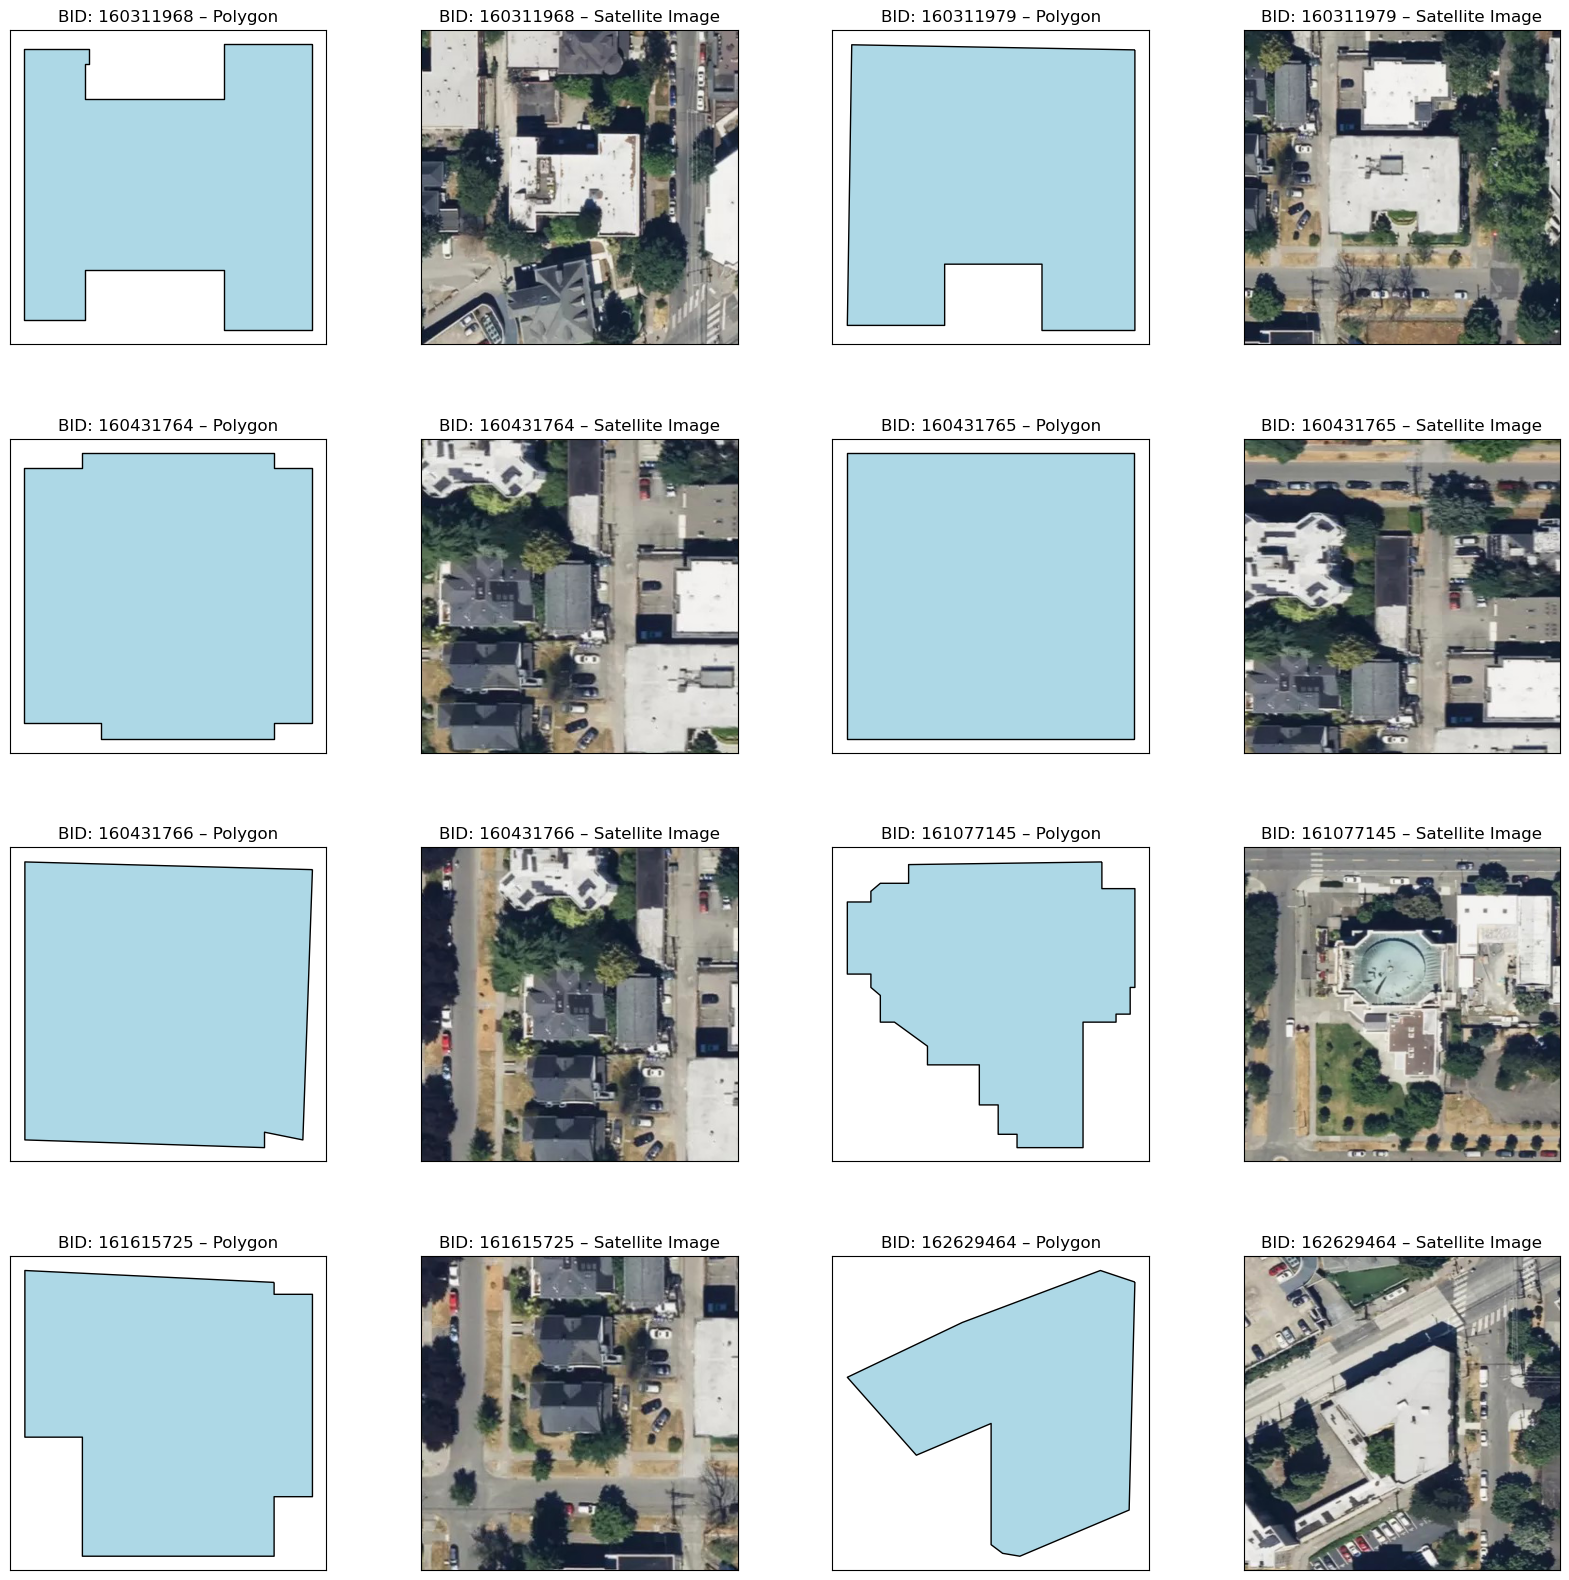

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

# Suppose your GeoDataFrame is called gdf and has a 'bid' column and geometry
# For illustration, we'll just assume you have 8 building IDs in total:
bids = buildings['bid'].unique()[17:25]

# Initialize figure and a 4x4 GridSpec
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(4,4, wspace=0.3, hspace=0.3)

for i, bid in enumerate(bids):
    # Determine row and column for this pair
    #
    # We have 4 rows total (0..3).
    # Each row has 4 columns (0..3).
    # Each row is split into 2 pairs: (col 0, col 1) and (col 2, col 3).
    # i // 2 is the row index, (i % 2)*2 is the column index for the polygon.
    row = i // 2
    col = (i % 2) * 2

    # 1) Plot the building polygon on the left subplot of the pair
    ax_poly = fig.add_subplot(gs[row, col])
    buildings[buildings['bid'] == bid].plot(ax=ax_poly, color='lightblue', edgecolor='black')
    ax_poly.set_title(f"BID: {bid} – Polygon")
    ax_poly.set_aspect('auto')
    ax_poly.set_xticks([])
    ax_poly.set_yticks([])

    # 2) Plot the corresponding satellite image on the right subplot
    ax_img = fig.add_subplot(gs[row, col+1])
    img_path = f'../building_satellite/{bid}.png'
    img = mpimg.imread(img_path)
    ax_img.imshow(img)
    ax_img.set_title(f"BID: {bid} – Satellite Image")
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    ax_img.set_aspect('auto')

plt.show()